# Rust Detection using Deep Learning

In [6]:
!pip install keras
!pip install tensorflow

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\ayush.kumar\Anaconda3\envs\$PYTHON36_ENV_NAME\lib\distutils\util.py", line 202, in subst_vars
    return re.sub(r'\$([a-zA-Z_][a-zA-Z_0-9]*)', _subst, s)
  File "C:\Users\ayush.kumar\Anaconda3\envs\$PYTHON36_ENV_NAME\lib\re.py", line 191, in sub
    return _compile(pattern, flags).sub(repl, string, count)
  File "C:\Users\ayush.kumar\Anaconda3\envs\$PYTHON36_ENV_NAME\lib\distutils\util.py", line 199, in _subst
    return os.environ[var_name]
  File "C:\Users\ayush.kumar\Anaconda3\envs\$PYTHON36_ENV_NAME\lib\os.py", line 669, in __getitem__
    raise KeyError(key) from None
KeyError: 'PYTHON36_ENV_NAME'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ayush.kumar\Anaconda3\envs\$PYTHON36_ENV_NAME\lib\site-packages\pip\_internal\cli\base_command.py", line 173, in _main
    status = self.run(options, args)
  File "C:\Users\ayush.kumar\Anaconda3\env

In [1]:
import keras
import tensorflow as tf
from keras.applications import VGG16
from keras.utils.vis_utils import plot_model
import os, shutil
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras import models
from keras.preprocessing import image
import numpy as np
import sklearn.metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import seaborn
print(keras.__version__)
print(tf.__version__)

Using TensorFlow backend.
c:\Users\ayush.kumar\Anaconda3\envs\$PYTHON36_ENV_NAME\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\ayush.kumar\Anaconda3\envs\$PYTHON36_ENV_NAME\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\ayush.kumar\Anaconda3\envs\$PYTHON36_ENV_NAME\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

2.2.4
1.12.0


# Using a pre-trained convnet
A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task. For instance, one might train a network on ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes), and use this to do binary classification of rust or no rust images.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture for ImageNet.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

Convnets used for image classification comprise two parts: they start with a series of pooling and convolution 
layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output.


Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from our rust and no rust images, and then train a rust vs. norust classifier on top of these features.

The VGG16 model, among others, comes pre-packaged with Keras. Here's the list of 
image classification models (all pre-trained on the ImageNet dataset) that are available as part of `keras.applications`:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19


Let's instantiate the VGG16 model:

In [2]:
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150, 150, 3))

We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this 
densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected 
classifier (with only two classes, rust and norust), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, 
then the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base:

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [4]:
plot_model(conv_base, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

The final feature map has shape `(4, 4, 512)`. That's the feature on top of which we will stick a densely-connected classifier.

* We extend the model we have (`conv_base`) by adding `Dense` layers on top, and run the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. 


In [6]:
# The path to the directory where the training images are downloaded, change this as in your system
original_dataset_dir = 'download'
original_dataset_dir_rust = 'download/rust'
original_dataset_dir_norust = 'download/norust'

# The directory where we will store our train, test and validation images
base_dir = 'rustnorust_b'


# Directories for our training,validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training rust pictures
train_rust_dir = os.path.join(train_dir, 'rust')

# Directory with our training norust pictures
train_norust_dir = os.path.join(train_dir, 'norust')

# Directory with our validation rust pictures
validation_rust_dir = os.path.join(validation_dir, 'rust')

# Directory with our validation norust pictures
validation_norust_dir = os.path.join(validation_dir, 'norust')

# Directory with our test rust pictures
test_rust_dir = os.path.join(test_dir, 'rust')

# Directory with our test norust pictures
test_norust_dir = os.path.join(test_dir, 'norust')

In [4]:
# Needed only for first time

In [7]:
os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)
os.mkdir(train_rust_dir)
os.mkdir(train_norust_dir)
os.mkdir(validation_rust_dir)
os.mkdir(validation_norust_dir)
os.mkdir(test_rust_dir)
os.mkdir(test_norust_dir)

# Needed only for first time

In [8]:
# Copy first 70 rust images to train_rust_dir
fnames = ['rust.{}.jpg'.format(i) for i in range(70)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_rust, fname)
    dst = os.path.join(train_rust_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 5 rust images to validation_rust_dir
fnames = ['rust.{}.jpg'.format(i) for i in range(70, 76)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_rust, fname)
    dst = os.path.join(validation_rust_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 6 rust images to test_rust_dir
fnames = ['rust.{}.jpg'.format(i) for i in range(76, 82)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_rust, fname)
    dst = os.path.join(test_rust_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 60 non-rust images to train_norust_dir
fnames = ['norust.{}.jpg'.format(i) for i in range(60)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_norust, fname)
    dst = os.path.join(train_norust_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 5 norust images to validation_norust_dir
fnames = ['norust.{}.jpg'.format(i) for i in range(60, 66)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_norust, fname)
    dst = os.path.join(validation_norust_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 5 norust images to test_norust_dir
fnames = ['norust.{}.jpg'.format(i) for i in range(63, 72)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_norust, fname)
    dst = os.path.join(test_norust_dir, fname)
    shutil.copyfile(src, dst)

In [9]:
print('total training rust images:', len(os.listdir(train_rust_dir)))
print('total training norust images:', len(os.listdir(train_norust_dir)))
print('total validation rust images:', len(os.listdir(validation_rust_dir)))
print('total validation norust images:', len(os.listdir(validation_norust_dir)))
print('total test rust images:', len(os.listdir(test_rust_dir)))
print('total test norust images:', len(os.listdir(test_norust_dir)))

total training rust images: 70
total training norust images: 60
total validation rust images: 6
total validation norust images: 6
total test rust images: 6
total test norust images: 9


We will leverage data augmentation during training: extending the `conv_base` model and running it end-to-end on the inputs. 

In [10]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This is what our model looks like now:

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 
million parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of 
layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were 
previously learned by the convolutional base would get modified during training. Since the `Dense` layers on top are randomly initialized, 
very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its `trainable` attribute to `False`:

In [12]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [13]:
conv_base.trainable = False 

In [14]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per 
layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. 
If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [15]:
base_dir = 'rustnorust_b'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')

 #       save_to_dir='/home/anirban/rustnorust_b/images')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary')

Found 130 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


In [16]:
from time import time
from keras.callbacks import TensorBoard
#callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.00001,patience=5,mode='min')]
tensorboard = keras.callbacks.TensorBoard(log_dir='/output/{}'.format(time()))

model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=2e-5),metrics=['acc'])

history = model.fit_generator(train_generator,steps_per_epoch=10,epochs=15,validation_data=validation_generator,validation_steps=20,verbose=2,callbacks=[tensorboard])

Epoch 1/15
 - 104s - loss: 0.6595 - acc: 0.6000 - val_loss: 0.5040 - val_acc: 0.7500
Epoch 2/15
 - 106s - loss: 0.5118 - acc: 0.8500 - val_loss: 0.4175 - val_acc: 1.0000
Epoch 3/15
 - 122s - loss: 0.4519 - acc: 0.9000 - val_loss: 0.3707 - val_acc: 1.0000
Epoch 4/15
 - 173s - loss: 0.4574 - acc: 0.8493 - val_loss: 0.3691 - val_acc: 0.9167
Epoch 5/15
 - 104s - loss: 0.3625 - acc: 0.9000 - val_loss: 0.3021 - val_acc: 1.0000
Epoch 6/15
 - 102s - loss: 0.4096 - acc: 0.8500 - val_loss: 0.2742 - val_acc: 1.0000
Epoch 7/15
 - 108s - loss: 0.3100 - acc: 0.8995 - val_loss: 0.2607 - val_acc: 1.0000
Epoch 8/15
 - 100s - loss: 0.3319 - acc: 0.8500 - val_loss: 0.2615 - val_acc: 1.0000
Epoch 9/15
 - 100s - loss: 0.2732 - acc: 0.9000 - val_loss: 0.2357 - val_acc: 1.0000
Epoch 10/15
 - 95s - loss: 0.4131 - acc: 0.7787 - val_loss: 0.2544 - val_acc: 1.0000
Epoch 11/15
 - 99s - loss: 0.2525 - acc: 0.8750 - val_loss: 0.2297 - val_acc: 1.0000
Epoch 12/15
 - 104s - loss: 0.2490 - acc: 0.9000 - val_loss: 0.21

In [17]:
model.save('rustnorust_b/rustnorust_model.h5') 

Let's plot our results again:

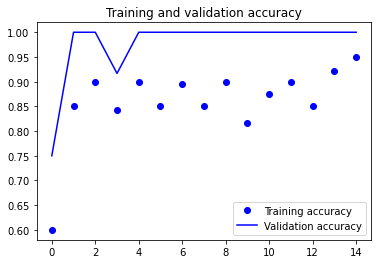

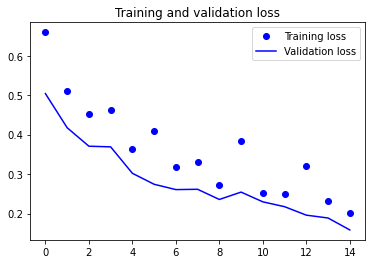

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

## If you want to try running the prediction from the saved model to validate the results, start from this step.

In [19]:
model = models.load_model('rustnorust_b/rustnorust_model.h5')

c:\Users\ayush.kumar\Anaconda3\envs\$PYTHON36_ENV_NAME\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


This is a Rust image


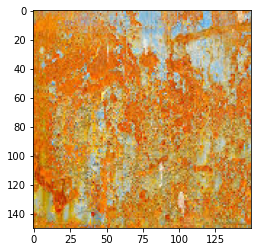

In [20]:
%matplotlib inline
img_path = 'rustnorust_b/test/rust/rust.81.jpg'

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

plt.imshow(img)
# Convert it to a Numpy array with shape (150, 150, 3)
test_x = image.img_to_array(img)
# Reshape it to (1, 150, 150, 3)
test_x = test_x.reshape((1,) + test_x.shape)
test_x = test_x.astype('float32') / 255
rust_prob = model.predict(test_x)

if (rust_prob > 0.5):
    print("This is a Rust image")
else:
    print("This is a no Rust image")

This is a no Rust image


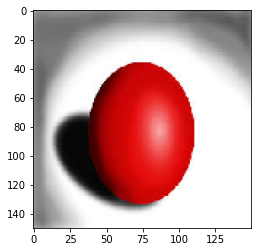

In [21]:
img_path = 'rustnorust_b/test/norust/norust.71.jpg'
img = image.load_img(img_path, target_size=(150, 150))
plt.imshow(img)
# Convert it to a Numpy array with shape (150, 150, 3)
test_x = image.img_to_array(img)
# Reshape it to (1, 150, 150, 3)
test_x = test_x.reshape((1,) + test_x.shape)
test_x = test_x.astype('float32') / 255
rust_prob = model.predict(test_x)

if (rust_prob > 0.5):
    print("This is a Rust image")
else:
    print("This is a no Rust image")

This is a no Rust image


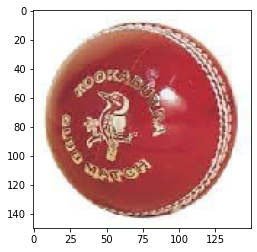

In [39]:
img_path = r"C:\Users\ayush.kumar\Desktop\CorrosionDectection_DATA\CorrosionDetector\download\norust\norust.18.jpg"
img = image.load_img(img_path, target_size=(150, 150))
plt.imshow(img)
# Convert it to a Numpy array with shape (150, 150, 3)
test_x = image.img_to_array(img)
# Reshape it to (1, 150, 150, 3)
test_x = test_x.reshape((1,) + test_x.shape)
test_x = test_x.astype('float32') / 255
rust_prob = model.predict(test_x)

if (rust_prob > 0.5):
    print("This is a 'Rust' image")
else:
    print("This is a 'No Rust' image")

In [24]:
base_dir = 'rustnorust_b'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')
       # save_to_dir='/home/anirban/rustnorust_b/images')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary')

Found 130 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


In [26]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=4,
        shuffle=False, 
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=10)
print('test acc:', test_acc)

Found 15 images belonging to 2 classes.
test acc: 0.9210526315789473


In [27]:
test_data_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=4,
        shuffle=False, # v imp : do not shuffle in case of test data, when measuring precision and recall
        class_mode='binary')

test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)

val_preds = np.zeros((predictions.shape[0],1))
for i in range(predictions.shape[0]):
    if predictions[i]>0.5:
        val_preds[i] = 1
    else:
        val_preds[i] = 0

val_trues = test_data_generator.classes

labels = test_data_generator.class_indices.keys()


Found 15 images belonging to 2 classes.


In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


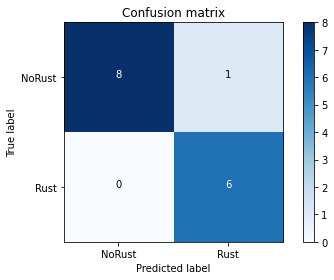

In [29]:
# Compute confusion matrix
class_names = ['NoRust','Rust']
cnf_matrix = confusion_matrix(val_trues, val_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

In [30]:
report = classification_report(val_trues, val_preds, target_names=labels)
print(report) 

              precision    recall  f1-score   support

      norust       1.00      0.89      0.94         9
        rust       0.86      1.00      0.92         6

    accuracy                           0.93        15
   macro avg       0.93      0.94      0.93        15
weighted avg       0.94      0.93      0.93        15



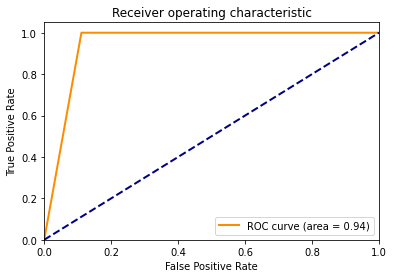

In [31]:
true_labels = val_trues
scores = val_preds
### actual code for roc + threshold charts start here 
# compute fpr, tpr, thresholds and roc_auc
fpr, tpr, thresholds = roc_curve(true_labels, scores)
roc_auc = auc(fpr, tpr) # compute area under the curve
 
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()